# Laboratory 01: Linear Regression

In developing machine learning algorithms the first step is to acquire and format the data such that it can be easily fed to and manipulated by the algorithms in question. To accomplish this task in this lab we will implement a common data science workflow called the Extract-Transform-Load process:

- __Extract__ -- implies getting the data from a source.
- __Transform__ -- implies formatting the data into a desirable format.
- __Load__ -- implies loading the data into a data structure suitable for query and analysis.

Then, we will use scikit-learn to design a Linear Regression predictor to forecast a stock price 30 days out. To aid us in this endeavour we'll use the following packages:

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline

#!pip install yfinance

import yfinance as yf # yahoo finance package to extrat our stock data
import pandas as pd # pandas to transform
from sklearn.model_selection import train_test_split # scikit model selection to load the data
from sklearn.linear_model import LinearRegression # to train our model


     |████████████████████████████████| 5.5MB 2.0MB/s 
  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=6503b88a566b35af868156cea1a760c2446dab8d57e535278711928657254619
  Stored in directory: /root/.cache/pip/wheels/04/98/cc/2702a4242d60bdc14f48b4557c427ded1fe92aedf257d4565c
Successfully built yfinance
  Found existing installation: lxml 4.2.6
    Uninstalling lxml-4.2.6:
      Successfully uninstalled lxml-4.2.6


## yfinance Package

[This package](https://github.com/ranaroussi/yfinance) allows us to get historical market data for almost any ticker (i.e. company stock symbol) we may require. For example, to get a pandas data frame containing the historical data we first need to instantiate a `ticker` object for the company stock we are interested in. That is, to instantiate such an object say for Microsoft Corp. we can do the following:

In [ ]:
stock = yf.Ticker('MSFT')

Here `Ticker()` is the constructor that accepts one argument, namely: the company stock symbol. In our case 'MSFT' is the company symbol for Microsoft Corp.

Now, we can get historical data up to this day, by using `.history()` method. This method accepts the following parameters:
- __period__: data period to download (either use `period` parameter or use `start/end`). Valid periods are: 1d, 5d, 1mo, 3mo, 6mo, 1y, 2y, 5y, 10y, ytd or max
- __interval__: data interval (intraday data cannot extend last 60 days). Valid intervals are: 1m, 2m, 5m, 15m, 30m, 60m, 90m, 1h, 1d, 5d, 1wk, 1mo, 3mo
- __start__: If not using period - Download start date string (YYYY-MM-DD) or datetime.
- __end__: If not using period - Download end date string (YYYY-MM-DD) or datetime.
- __prepost__: Include Pre and Post market data in results? (Default is False)
- __auto_adjust__: Adjust all OHLC automatically? (Default is True)
- __actions__: Download stock dividends and stock splits events? (Default is True)


To get the OHLC (Open-High-Low-Close) for the last five days we can do:

In [ ]:
stock.history(period='5d')

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-19,220.419998,222.300003,213.720001,214.220001,27625800,0,0
2020-10-20,215.800003,217.369995,213.089996,214.649994,22753500,0,0
2020-10-21,213.119995,216.919998,213.119995,214.800003,22724900,0,0
2020-10-22,213.929993,216.059998,211.699997,214.889999,22351500,0,0
2020-10-23,215.029999,216.279999,213.160004,216.229996,18841600,0,0


Or we can get the entire stock history to date by:

In [ ]:
stock.history(period='max').head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1986-03-13,0.056514,0.064825,0.056514,0.062055,1031788800,0.0,0.0
1986-03-14,0.062055,0.065379,0.062055,0.064271,308160000,0.0,0.0
1986-03-17,0.064271,0.065933,0.064271,0.065379,133171200,0.0,0.0
1986-03-18,0.065379,0.065933,0.063163,0.063717,67766400,0.0,0.0
1986-03-19,0.063717,0.064271,0.062055,0.062609,47894400,0.0,0.0


Similarly, we can specify an interval such as:

In [ ]:
stock.history(start='2019-01-01', end='2020-01-01').head()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2019-01-02,97.325300,99.476133,96.728932,98.860214,35329300,0.0,0
2019-01-03,97.863009,97.951002,95.027816,95.223351,42579100,0.0,0
2019-01-04,97.491504,100.219155,96.719158,99.652115,44060600,0.0,0
2019-01-07,99.368593,100.962164,98.723346,99.779205,35656100,0.0,0
2019-01-08,100.737305,101.646522,99.437025,100.502670,31514400,0.0,0


Of course, the `yfinance` package has many other features to get information about a company and you should definitely check it out. However, in this lab getting historical data for stocks will suffice.

## sklearn Package

[Scikit-learn](https://scikit-learn.org/stable/tutorial/basic/tutorial.html) is a machine learning package that provides a range of supervised and unsupervised learning (classical) algorithms via a consistent interface in Python. The library is built upon the SciPy (Scientific Python) and the stack includes:
- NumPy: Base n-dimensional array package
- SciPy: Fundamental library for scientific computing
- Matplotlib: Comprehensive 2D/3D plotting
- IPython: Enhanced interactive console
- Sympy: Symbolic mathematics
- Pandas: Data structures and analysis


### sklearn.model_selection

Includes functionalities to evaluate estimator performance, tune the hyper-parameters, generate dataset splits and integrate model validation techniques. In this laboratory we are interested in generating dataset splits via the [`train_test_split()`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html#sklearn.model_selection.train_test_split) function. 

Lets assume we have a dataset described by an input (matrix) X that represents our features, and an output (vector) y that represents our target. What we want to do in order to evaluate our model is to split our dataset in two subsets: train and test, i.e. (X_train, y_train) and (X_test, y_test) pairs. We can accomplish this by calling: 
```Python

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
```
which in this case outputs a split where 30\% of the data was reserved for the subset (X_test, y_test), while the rest of 70\% forms the (X_train, y_train) subset. Of course, at our disposal are a few more options to customize a split further, such as:

- __shuffle__ -- bool values which if True shuffles the data before splitting
- __stratify__ -- array-like structure that specifies how the samples in the data set should be organized, i.e. the resulting (X_train, y_train) and (X_test, y_test) contain the same proportion class targets
- and a few others

### sklearn.linear_model

Implements generalized linear models, including Ridge regression, Bayesian Regression, Lasso and Elastic Net estimators computed with Least Angle Regression and coordinate descent. It also implements Stochastic Gradient Descent related algorithms. For example, we can instantiate a simple linear regressor with
```Python
reg = LinearRegression()
```

And assuming our data is organized as an (X, y) feature, target pair we can train the linear regressor via the `.fit()` method as in:

```Python
reg.fit(X, y)
```

Moreover, after training we can use the model to make predictions via the `.predict()` method:

```Python
y_pred = reg.predict(X)
```

## Exercises

For the purpose of forecasting a stock price we will use the Microchip Corp. ticker symbol __'MCHP'__ and will approach the problem in a series of successive tasks.


## Task 1 - Extracting the data

Use the yfinance package to extract all daily historical data for Microchip Corp. in a data frame called `mchp_hist_df` and investigate its format:
- print the last 10 rows of data
- print the dataframe shape
- print the information about the dataframe
- print the number of missing values for each column

In [ ]:
# Task 1
# TODO 1.1. Getting the data: instantiate Ticker and get its history 
mchp_hist_df = yf.Ticker('MCHP').history(period='max')

In [ ]:
# TODO 1.2. Print the last 10 rows of the dataframe
mchp_hist_df.tail(10)

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-10-12,115.360001,115.500000,113.620003,114.129997,2024700,0.0,0.0
2020-10-13,112.760002,113.000000,111.080002,111.580002,1887300,0.0,0.0
2020-10-14,111.580002,112.300003,110.459999,110.750000,1192900,0.0,0.0
2020-10-15,109.379997,111.459999,108.860001,111.339996,986700,0.0,0.0
2020-10-16,111.760002,112.339996,110.730003,110.809998,1437500,0.0,0.0
2020-10-19,114.989998,115.040001,111.000000,111.660004,1547500,0.0,0.0
2020-10-20,112.209999,113.779999,111.220001,111.230003,1231900,0.0,0.0
2020-10-21,111.360001,112.309998,109.839996,110.480003,1113700,0.0,0.0
2020-10-22,110.510002,112.879997,109.550003,112.519997,1792400,0.0,0.0


In [ ]:
# TODO 1.3. Print the dataframe shape
mchp_hist_df.shape

(6952, 7)

In [ ]:
# TODO 1.4. Print the dataframe information
mchp_hist_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6952 entries, 1993-03-19 to 2020-10-23
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Open          6952 non-null   float64
 1   High          6952 non-null   float64
 2   Low           6952 non-null   float64
 3   Close         6952 non-null   float64
 4   Volume        6952 non-null   int64  
 5   Dividends     6952 non-null   float64
 6   Stock Splits  6952 non-null   float64
dtypes: float64(6), int64(1)
memory usage: 434.5 KB


In [ ]:
# TODO 1.5. Print the number of missing values
mchp_hist_df.isnull()

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
1993-03-19,False,False,False,False,False,False,False
1993-03-22,False,False,False,False,False,False,False
1993-03-23,False,False,False,False,False,False,False
1993-03-24,False,False,False,False,False,False,False
1993-03-25,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...
2020-10-19,False,False,False,False,False,False,False
2020-10-20,False,False,False,False,False,False,False
2020-10-21,False,False,False,False,False,False,False


## Task 2 - Transforming the data

Now that you have extracted the data, its time to transform it such that we can latter input it to the Linear Regression model. Since the goal is to forecast the stock price 30 days out, you only need the closing price. Hence, the first thing you need to do here is to create a new dataframe, `mchp_close_df`, that contains only the 'Close' column values in a column called 'features'.

In [ ]:
#  Task 2

# TODO 2.1. Create a mchp_close_df
mchp_close_df = mchp_hist_df[['Close']]
mchp_close_df.columns = ['features']

To make sure everything worked as expected print the head of `mchp_close_df`. You should see the date index as before and single column named `features`. Note, that if you get a pandas warning you probably didn't instantiate an empty dataframe first (i.e. use `pd.DataFrame()`).

In [ ]:
# TODO 2.2. Create a mchp_close_df
mchp_close_df.head()

,features
Date,
1993-03-19,0.393947
1993-03-22,0.377395
1993-03-23,0.377395
1993-03-24,0.384015
1993-03-25,0.400568


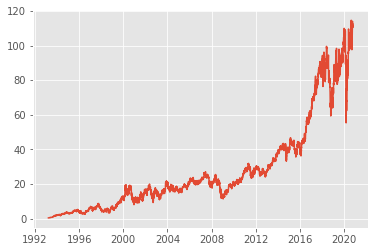

In [ ]:
# TODO 2.3. Plot the closing price trend
plt.plot(mchp_close_df)

Now, you need to create a new column, `target`, for the target prediction. Since, our forecasting is 30 days out the `target` column is shifted version of the `features` column. 

In [ ]:
forcast_period = 30

# TODO 2.4. Add the 'target' column to mchp_close_df
# Hint: Use shift method on the features column
mchp_close_df['target'] = mchp_close_df.shift(-forcast_period)
# TODO 2.5. Print the number of missing values in mchp_close_df
mchp_close_df.isnull().sum().sum()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


30

Note, that the shift produced 30 NaN values for the last 30 entries in the 'target' column. Thus, you need to remove those values.

In [ ]:
# TODO 2.6. Remove all NaN
mchp_close_df.dropna(inplace=True)
# TODO 2.7. Print mchp_close_df tail
mchp_close_df.tail()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,features,target
Date,,
2020-07-24,99.868927,108.150002
2020-07-27,102.739120,102.879997
2020-07-28,100.177864,101.449997
2020-07-29,102.340485,100.599998
2020-07-30,101.901985,100.699997


## Task 3 - Loading the Data

Here, you need to load the data such that the result is a (X, y) pair of n-arrays of features and targets such we can use them within sklearn API calls.

Don't forget to reshape X, y appropriately.

In [ ]:
#  Task 3

# TODO 3.1. Create the (X, y) pair of features and targets
# Hint: both X and y need to be m rows by 1 cloumn
X = mchp_close_df.drop(['target'], 1)
y = mchp_close_df['target']

Finally, you need to split the data in train and test set, such that we can latter evaluate our model. The split in this case can be 80\% for train and 20\% for test.

In [1]:
# TODO 3.2. Do a 80/20 split for train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

NameError: ignored

## Task 4 -  Training a model

Congrats, now train a `LinearRession()` and generate predictions for both train and test sets, namely: `y_train_pred` and `y_test_pred`.

In [3]:
# Task 4

# TODO 4.1. Train a LinearRegession model
lr = LinearRegression()
lr.fit(X_train, y_train)

NameError: ignored

In [ ]:
# TODO 4.2. Generate train and test sets predictions
y_train_pred = lr.predict(X_train)
y_test_pred = lr.predict(X_test)

## Task 5 - Evaluate a model

To evaluate our model we can compute the mean squared error loss for both training and testing subset. To do this you can use the `mean_squared_error(actual, predicted)` from `sklearn.metric` which has been imported for you.

In [ ]:
from sklearn.metrics import mean_squared_error 

In [ ]:
# Task 5

# TODO 5.1. Compute the MSE for train set
mse_train = mean_squared_error(y_train, y_train_pred)

# TODO 5.2. Compute the MSE for train set
mse_test = mean_squared_error(y_test, y_test_pred)

In [ ]:
# TODO 5.3. Print both errors
print(mse_train, mse_test)

19.891191460205558 15.745268458991507


In [ ]:
# Printing the R^2 score (i.e. confidence of the model, where 1 means perfect classification)
print("R^2 Train: {}".format(lr.score(X_train, y_train)))
print("R^2 Test: {}".format(lr.score(X_test, y_test)))

R^2 Train: 0.9709040026075813
R^2 Test: 0.9749133750963193


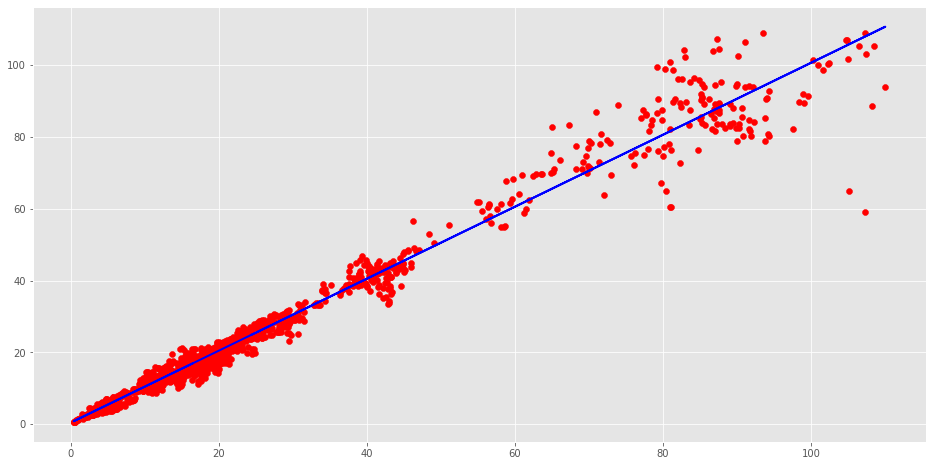

In [ ]:
# Ploting the results
plt.figure(figsize=(16,8))
plt.scatter(X_test, y_test,  color='red')
plt.plot(X_test, y_test_pred, color='blue', linewidth=2)


Wow, you got above 90\% confidence! Can you make money with this model?  Why is the model so good? 

The model has a very good score because of overfitting. The parameters are biased towards these specific data points, thus not working well for the real problem.